In [1]:
from collections import namedtuple

from scipy.optimize import minimize
from sympy.abc import x, y
from sympy.plotting import plot3d
import numpy as np
import plotly.graph_objects as go
import sympy as sym

**Содержание**<a id='toc0_'></a>    
- [__Градиентный спуск (GD), примеры кода__](#toc1_1_1_)    
- [__Cтохастический градиентный спуск (SGD)__](#toc1_1_2_)    
- [__Градиентный спуск с моментом (Momentum)__](#toc1_1_3_)    
- [__RMSprop (Root Mean Square propagation)__](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
### <a id='toc1_1_1_'></a>[__Градиентный спуск (GD), примеры кода__](#toc0_)

__Задача__. Для заданной функции найти положение после шага градиентного спуска с learning rate $\lambda = 1/20$.

In [2]:
def derivHandmade(f, *, n=1, x0=None):
    if callable(f):
        f = f(x)
    deriv = sym.diff(f, x, n)
    if x0 is not None:
        return sym.lambdify(x, deriv)(x0)
    return deriv

In [3]:
f = lambda x: 5*x**4 + 12*x**2 - 4*x + 9
r1, lrate = 1, 1/20

r1 - lrate * derivHandmade(f, x0=r1)  # r2

-1.0

Обобщение:

In [4]:
def inNsteps(f, *, curr_val, lrate, nsteps):
    deriv = sym.lambdify(x, derivHandmade(f))
    for _ in range(nsteps):
        curr_val -= lrate * deriv(curr_val)
        # curr_val -= lrate * derivHandmade(f, x0=curr_val)
        # плохо из-за повторного дифференцирования в цикле
    return curr_val

In [5]:
[inNsteps(x**2, curr_val=1024, lrate=1/4, nsteps=nsteps) for nsteps in (1, 2, 13)]

[512.0, 256.0, 0.125]

Расчет числа шагов для вхождения в заданную $\varepsilon$-окрестность:

In [6]:
def getNsteps(f, *, curr_val, lrate, eps):
    nsteps = 0
    deriv = sym.lambdify(x, derivHandmade(f))
    while abs(d := deriv(curr_val)) >= eps:
        curr_val -= lrate * d
        nsteps += 1
    return nsteps

In [7]:
getNsteps(x**2, curr_val=-512, lrate=1/4, eps=1/10)

14

__Задача__. Градиентный спуск для функции $f(x,y) = (x - 50)^2 + (y - 50)^2$ стартует из точки $(0, 100)$. Найти число шагов до завершения спуска при значениях скорости обучения $0.9, \ 0.99, \ 0.999, \ 1$.

In [8]:
varbs = x, y
f = (x - 50)**2 + (y - 50)**2

In [9]:
# приготовленные для многократных вызовов функции частных производных
pderivs = [sym.lambdify([x, y], sym.diff(f, var)) for var in varbs]

In [10]:
GDReport = namedtuple('GDReport', ['final_location', 'nsteps'])

In [11]:
def gradient(point):
    return np.array([func(*point) for func in pderivs], dtype=float)

In [12]:
def gradient_descent(lrate, point=(0,100), max_steps=1e4, eps=1e-3):
    nsteps = 0
    while all([nsteps < max_steps,
               np.linalg.norm(grad := gradient(point)) >= eps]): 
        point -= lrate * grad
        nsteps += 1
    return GDReport(final_location=point, nsteps=nsteps)

In [13]:
[gradient_descent(lrate=lrate) for lrate in (.9, .99, .999, 1)]
# 136 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

[GDReport(final_location=array([49.9997077, 50.0002923]), nsteps=54),
 GDReport(final_location=array([49.99965334, 50.00034666]), nsteps=588),
 GDReport(final_location=array([49.99964658, 50.00035342]), nsteps=5924),
 GDReport(final_location=array([  0., 100.]), nsteps=10000)]

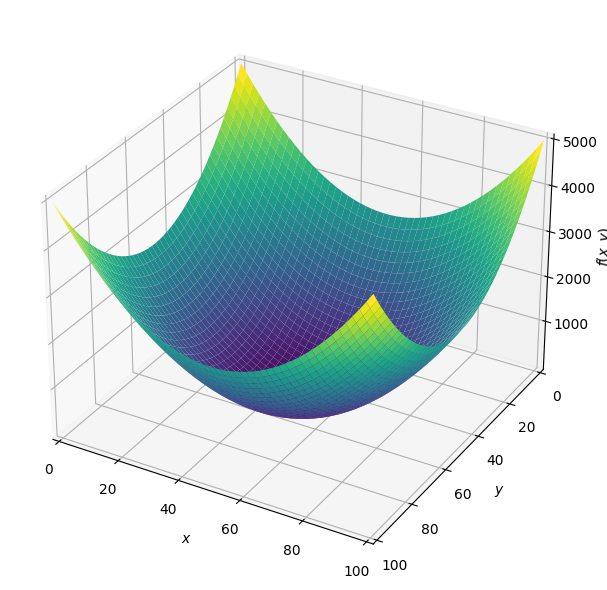

In [14]:
plot3d(f, (x, 0, 100), (y, 100, 0), size=(6,6))

In [15]:
# f = lambda x, y: (x - 50)**2 + (y - 50)**2

# также возможно, но медленнее:
# z = np.array([[int(f.subs({x: i, y: j})) for i in range(101)]
#               for j in range(101)])

f = sym.lambdify([x, y], f)
z = np.array([[f(i, j) for i in range(101)] for j in range(101)])
fig = go.Figure(data=[go.Surface(z=z)])
fig.update_layout(width=800, height=600, margin=dict.fromkeys('lrtb', 0))
fig.show()

In [16]:
# nit: 3
f = lambda x: (x[0] - 50)**2 + (x[1] - 50)**2
minimize(f, (0,100))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.440898855203584e-16
        x: [ 5.000e+01  5.000e+01]
      nit: 3
      jac: [-1.489e-08 -1.491e-08]
 hess_inv: [[ 7.500e-01  2.500e-01]
            [ 2.500e-01  7.500e-01]]
     nfev: 18
     njev: 6

__Задача__. На заданном объекте найти градиент квадратичной функции потерь в точке $(0, 2, 5)$. 

In [17]:
th0, th1, th2 = thetas = sym.symbols('th0 th1 th2')
x = np.array([1, 4, 6])  # описание объекта вектором значений признаков
y = 35  # правильный ответ на объекте
th_vals = 0, 2, 5

J = 1/2 * (thetas @ x - y)**2  # квадратичная функция потерь (от тета)
d = dict(zip(thetas, th_vals))
beautify = lambda n: int(n) if not n % 1 else float(n)

tuple(beautify(sym.diff(J, th).subs(d)) for th in thetas)

(3, 12, 18)

***
### <a id='toc1_1_2_'></a>[__Cтохастический градиентный спуск (SGD)__](#toc0_)
В GD шаг зависит от градиента функции потерь для всех $m$ объектов обучающей выборки. В SGD шаг делается исходя из информации только об одном объекте обучающей выборки. Итого $m$ шагов, по одному для каждого объекта из данной перестановки. Проход по перестановке называется _эпохой_. Число $k$ взятых перестановок - _числом эпох_. Итого количество шагов - $m * k$.

__Mini-batch GD__ - разновидность SGD, компромисс между вычислительно затратным GD и неточным SGD: выборка случайным образом пакетируется, но внутри пакета учитываются все объекты, - функция потерь суммируется по всем объектам данного пакета. Как и в обычном SGD возможны несколько эпох. Поскольку пакеты не пересекаются, каждый объект в ходе данной эпохи просматривается один раз. Общее число просмотров любого данного объекта равно числу эпох.

***
### <a id='toc1_1_3_'></a>[__Градиентный спуск с моментом (Momentum)__](#toc0_)
Идея: Шаг спуска пропорционален не просто градиенту функции потерь на текущем шаге, как в классическом случае, а экспоненциально взвешенному среднему градиентов на текущем и прошлых шагах. "Память", или чувствительность к ранним данным, или баланс между ними и более свежими, регулируется коэффициентом момента $\beta$.

Для удобства разделим функцию момента $V_t = \beta V_{t-1} + (1-\beta)S_t$ на две - символьную, для наглядного вывода в latex, и подфункцию счета коэффициентов (весов) при градиентах $S$:

In [18]:
def Vt_symb(beta, t):
    S = [sym.Indexed('S', i) for i in range(1, t+1)]
    betas = np.array([beta**p for p in range(t-1, -1, -1)])
    return (1 - beta) * (betas @ S)

In [19]:
def Vt_coef(beta, t):
    return np.array([(1 - beta) * beta**p for p in range(t-1, -1, -1)])

In [20]:
t = 5
x = np.arange(1, t+1)

In [21]:
Vt_symb(sym.Symbol('beta'), t)

(1 - beta)*(beta**4*S[1] + beta**3*S[2] + beta**2*S[3] + beta*S[4] + S[5])

In [22]:
Vt_symb(.8, t)

0.08192*S[1] + 0.1024*S[2] + 0.128*S[3] + 0.16*S[4] + 0.2*S[5]

In [23]:
Vt_symb(.9, t)

0.06561*S[1] + 0.0729*S[2] + 0.081*S[3] + 0.09*S[4] + 0.1*S[5]

Геометрическая интерпретация. Угловые коэффициенты (slope) линейной регрессии весов $S$ при разных $\beta$. С ростом $\beta$ линия прижимается к оси абсцисс: веса растут, но медленнее.

In [24]:
[round(np.polyfit(x, Vt_coef(beta, t), deg=1)[0], 6) for beta in (.8, .9)]

[0.029376, 0.008588]

Рост $\beta$ размывает относительное влияние более поздних слагаемых, делая спуск более инертным. Уменьшение $\beta$, напротив, усиливает влияние более поздних слагаемых, и, при $\beta = 0$, GD с моментом вырождается в обычный GD:

In [25]:
Vt_symb(0, t)

S[5]

Показывается раскрытием скобок,
$$(1+\beta+\beta^2+...+\beta^{t-2}+\beta^{t-1})(1-\beta)=1-\beta^t.$$

При делении $V_t$ на $1-\beta^t$ получается экспоненциально взвешенное среднее $t$ градиентов:

$$\frac{(1-\beta)(S_t+\beta S_{t-1}+\beta^2 S_{t-2}+...+\beta^{t-2} S_2+\beta^{t-1} S_1)}{(1-\beta)(1+\beta+\beta^2+...+\beta^{t-2}+\beta^{t-1})} = $$

$$= \frac{(S_t+\beta S_{t-1}+\beta^2 S_{t-2}+...+\beta^{t-2} S_2+\beta^{t-1} S_1)}{(1+\beta+\beta^2+...+\beta^{t-2}+\beta^{t-1})},$$
 
поскольку в знаменателе сумма коэффициентов перед градиентами в числителе.

Шаг GD с моментом: 
$$\Large \frac{-\alpha}{1-\beta^t} V_t$$

См. также [__pandas.DataFrame.ewm__](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html?highlight=ewm#pandas-dataframe-ewm).

***
### <a id='toc1_1_4_'></a>[__RMSprop (Root Mean Square propagation)__](#toc0_)
Идея: Нормировка $j$-ой координаты градиента корнем квадратным из экспоненциально взвешенного среднего квадратов $j$-ой координаты первых $t$ векторов градиента. Это пример адаптивной скорости обучения, _adaptive learning rate_.

In [26]:
RMSpropReport = namedtuple('RMSpropReport', ['u_vec', 'step_vec'])

In [27]:
def RMSprop(grad_arr, *, t, alpha=1, beta=.9, eps=1e-8):
    betas = np.array([beta**p for p in range(t-1, -1, -1)])
    grad = grad_arr[:t]
    u = (1 - beta) * (betas @ grad**2)
    step = -alpha * grad[t-1] / (np.sqrt(u / (1 - beta**t)) + eps)
    return RMSpropReport(u_vec=u, step_vec=step)

In [28]:
grad_arr = np.array([[5, 2, 0], [-7, 3, 0], [6, 4, -1]])

In [29]:
RMSprop(grad_arr, t=2)

RMSpropReport(u_vec=array([7.15, 1.26, 0.  ]), step_vec=array([ 1.14109504, -1.16496474,  0.        ]))

In [30]:
RMSprop(grad_arr, t=3)

RMSpropReport(u_vec=array([10.035,  2.734,  0.1  ]), step_vec=array([-0.98600066, -1.25934691,  1.64620774]))